# Quantum Algorithms 

## Table of Contents

### [Oracular](#Oracular)
* [Deutsch-Jozsa Algorithm](#Deutsch-Jozsa-Algorithm)
* [Bernstein-Vazirani Algorithm](#Bernstein-Vazirani-Algorithm)
* [Simon's Algorithm](#Simon's-Algorithm)

<!-- -->

### [Protocols](#Protocols)

In [14]:
import numpy as np

from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, assemble, transpile
from qiskit.visualization import plot_histogram

# Oracular

## Deutsch-Jozsa Algorithm

**Problem:** Given a oracle $U_f$ which implements some function $f:\{0,1\}^n \to \{0,1\}$ as $U_f: \left|x\right>\left|y\right> \mapsto \left|x\right>\left|y\oplus f(x)\right>$ with $f$ promised to be either balanced or constant.  Determine whether $f$ is balanced or constant.

<!-- -->

**Hadamard gate:** for arbitrary n-qubit
$$
\left| x \right> \xrightarrow{H^{\otimes n}} \frac{1}{\sqrt{2^n}} \sum_{y\in \{0,1\}^{n}}(-1)^{x\cdot y} \left|y\right>
$$

<!-- -->

**Algorithm:**

<!-- -->

1. Initialize $\left|0\right>^{\otimes n} \otimes \left|1\right>$
2. Apply Hadamard gate to each qubit
3. Query the oracle $U_f$
4. Apply Hadamard gates to control qubits
5. Measure

<!-- -->
$$
\left|0\right>^{\otimes n}   \xrightarrow{H^{\otimes n}} \frac{1}{\sqrt{2^{n}}}\sum_{x \in \{0,1\}^{n}}\left|x\right> \xrightarrow{U_f} \frac{1}{\sqrt{2^{n}}}\sum_{x \in \{0,1\}^{n}} (-1)^{f(x)}\left|x\right>   \xrightarrow{H^{\otimes n}} \frac{1}{2^n}\sum_{x,y\in \{0,1\}^{n}} (-1)^{f(x)+x\cdot y}\left|y\right>
$$

<!-- -->

**Note:** The probability of measuring $\left|0^{\otimes n}\right> = \left|\frac{1}{2^n}\sum_{x \in \{0,1\}^n} (-1)^{f(x)} \right|^2$ which is **1** if f is **constant** and **0** if f is **balanced**.


### Deutsch-Jozsa Algorithm Qiskit Implementation 

In [15]:
def dj_oracle(case, n):
    oracle = QuantumCircuit(n+1)
    
    # Balanced Oracle
    if case == "balanced":
        
        # Produce the binary string that dictates the form of the balanced oracle 
        b = np.random.randint(1,2**n)
        b_str = format(b, '0'+str(n)+'b')
        
        #Wrap the initial balanced oracle with X-gates according to b_str
        for q in range(len(b_str)):
            if b_str[q] == '1':
                oracle.x(q)
                
        #Initial balanced oracle 
        oracle.cx(range(n), n)
        
        for q in range(len(b_str)):
            if b_str[q] == '1':
                oracle.x(q)

    # Constant Oracle 
    if case == "constant":
        # The output of the function is either 0 or 1
        output = np.random.randint(2)
        #If 1 then the oracle is equivalent X-gate on the auxillary
        if output == 1:
            oracle.x(n)
    
    oracle_gate = oracle.to_gate()
    oracle_gate.name = "Oracle" 
    return oracle_gate

In [16]:
def dj_algorithm(oracle, n):
    dj = QuantumCircuit(n+1, n)
    
    # Set up the auxillary qubit:
    dj.x(n)
    dj.h(n)
    
    # Set up the control qubits:
    dj.h(range(n))
        
    # Append the oracle gate:
    dj.append(oracle, range(n+1))
    
    # Pad the control qubits with the H-gates
    dj.h(range(n))
    
    # Measure the control qubits
    dj.measure(range(n), range(n))
    
    return dj

In [42]:
# Example for Deutsch-Josza algorithm
n = 3
oracle_gate = dj_oracle('balanced', n)
#oracle_gate = dj_oracle('constant', n)
dj_circuit = dj_algorithm(oracle_gate, n)
dj_circuit.draw()


┌───┐     ┌─────────┐┌───┐┌─┐      
q_0: ┤ H ├─────┤0        ├┤ H ├┤M├──────
     ├───┤     │         │├───┤└╥┘┌─┐   
q_1: ┤ H ├─────┤1        ├┤ H ├─╫─┤M├───
     ├───┤     │  Oracle │├───┤ ║ └╥┘┌─┐
q_2: ┤ H ├─────┤2        ├┤ H ├─╫──╫─┤M├
     ├───┤┌───┐│         │└───┘ ║  ║ └╥┘
q_3: ┤ X ├┤ H ├┤3        ├──────╫──╫──╫─
     └───┘└───┘└─────────┘      ║  ║  ║ 
c: 3/═══════════════════════════╩══╩══╩═
                                0  1  2

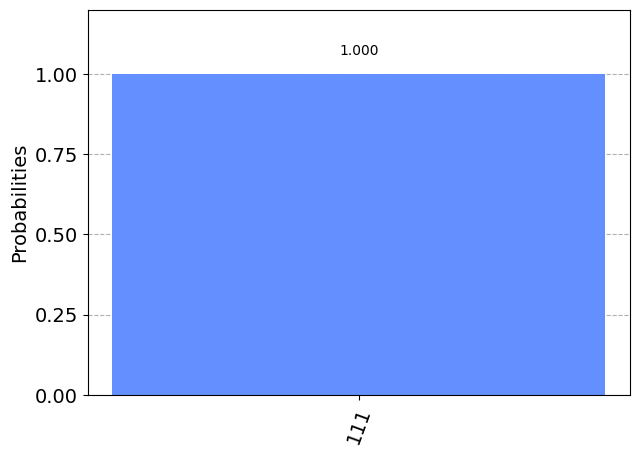

In [18]:
aer_sim = Aer.get_backend('aer_simulator')
transpiled_dj_circuit = transpile(dj_circuit, aer_sim)
qobj = assemble(transpiled_dj_circuit)
results = aer_sim.run(qobj).result()
answer = results.get_counts()

# as expect that the probability of measuring 000 is 0 for balanced f v.s.
plot_histogram(answer)

## Bernstein-Vazirani Algorithm

**Problem:** $f: \{0,1\}^{n} \to \{0,1\}$ with $f(x) = s\cdot x \,\, \text{(mod 2)}$ for some string $s$. Find the string $s$.

<!-- -->

**Phase Kickback:** when the auxillary qubit is $\left| - \right>$

$$
\left|x\right>\xrightarrow{f_s} (-1)^{s\cdot x} \left|x\right>
$$
<!-- -->

**Algorithm:**
1. Initialize  $\left|0\right>^{\otimes n}\otimes \left|1\right>$
2. Apply Hadamard gates to each qubit
3. Query the oracle
4. Apply Hadamard gates to the control qubits
5. Measure the control qubits

<!-- -->

$$
\left|0^{\otimes n}\right> \xrightarrow{H^{\otimes n}} \frac{1}{\sqrt{2^n}} \sum_{x\in \{0,1\}^{n}}\left|x\right> \xrightarrow{f_s} \frac{1}{\sqrt{2^n}} \sum_{x\in \{0,1\}^{n}}(-1)^{s\cdot x}\left|x \right> \xrightarrow{H^{\otimes n}} \left|s \right>
$$

### Bernstein-Vazirani Algorithm: Qiskit Implementation

In [19]:
def bv_algorithm(s):
    n = len(s)
    bv = QuantumCircuit(n+1,n)
    
    # Set up the auxillary qubit:
    bv.x(n)
    bv.h(n)
    
    # Set up the control qubits:
    bv.h(range(n))
        
    bv.barrier()
    
    # Oracle (addition by 1 is equivalent to X gate in mod 2)
    s = s[::-1]
    for q in range(n):
        if s[q] == '1':
            bv.cx(q, n)
       
    bv.barrier()
    
    # Pad off the control qubits
    bv.h(range(n))
        
    #Measurement
    bv.measure(range(n), range(n))
    
    return bv

In [41]:
s = "0101"
bv_circuit = bv_algorithm(s)
bv_circuit.draw()

┌───┐      ░            ░ ┌───┐┌─┐         
q_0: ┤ H ├──────░───■────────░─┤ H ├┤M├─────────
     ├───┤      ░   │        ░ ├───┤└╥┘┌─┐      
q_1: ┤ H ├──────░───┼────────░─┤ H ├─╫─┤M├──────
     ├───┤      ░   │        ░ ├───┤ ║ └╥┘┌─┐   
q_2: ┤ H ├──────░───┼────■───░─┤ H ├─╫──╫─┤M├───
     ├───┤      ░   │    │   ░ ├───┤ ║  ║ └╥┘┌─┐
q_3: ┤ H ├──────░───┼────┼───░─┤ H ├─╫──╫──╫─┤M├
     ├───┤┌───┐ ░ ┌─┴─┐┌─┴─┐ ░ └───┘ ║  ║  ║ └╥┘
q_4: ┤ X ├┤ H ├─░─┤ X ├┤ X ├─░───────╫──╫──╫──╫─
     └───┘└───┘ ░ └───┘└───┘ ░       ║  ║  ║  ║ 
c: 4/════════════════════════════════╩══╩══╩══╩═
                                     0  1  2  3

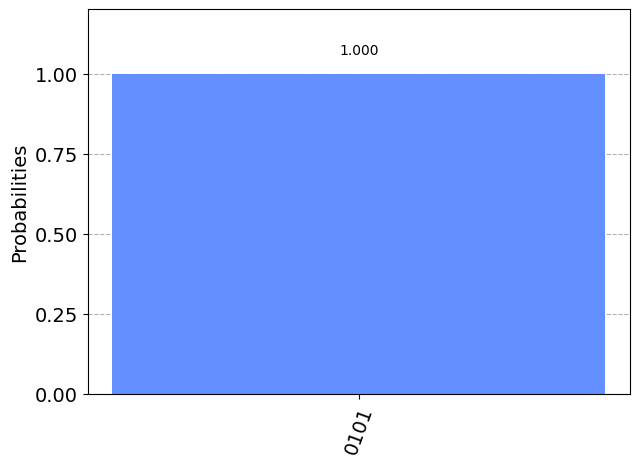

In [21]:
aer_sim = Aer.get_backend('aer_simulator')
qobj = assemble(bv_circuit)
results = aer_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)

## Simon's Algorithm

**Problem:** Given a function, implemented by an oracle, $f: \{0,1\}^{n} \to \{0,1\}^{n}$ with the promise that for some unknown $s\in \{0,1\}^n$ for all $x,y \in \{0,1\}^{n}$

$$
f(x) = f(y) \iff x \oplus y \in \{0^n,s\}
$$

Find $s$ as few queries to $f(x)$ as possible. Note: $s =0$ implies $f$ is 1-1 and $s\neq 0$ implies $f$ is 2-1. The query function $Q_f$ acts on two quantum register as $\left|x\right>\left|a\right> \to \left|x\right> \left|a\oplus f(x)\right>$

<!-- -->

**Algorithm:**

<!-- -->

1. Intialize $\left|0\right>^{\otimes n} \otimes \left|0\right>^{\otimes n}$
2. Apply Hadamard gates to the first register
3. Query the oracle $Q_f$
4. Measure the second register 
5. Apply Hadamard gates to the first register

<!-- -->

\begin{align*}
\left|0\right>^{\otimes n} \left|0\right>^{\otimes n}  &\xrightarrow{H^{\otimes n}}\frac{1}{\sqrt{2^n}} \sum_{x\in \{0,1\}^{n}}\left|x\right>\left|0\right>^{\otimes n} \xrightarrow{Q_f} \frac{1}{\sqrt{2^n}} \sum_{x\in \{0,1\}^{n}}\left|x\right>\left|f(x)\right>\\
&\xrightarrow{\text{measure r2}}   \frac{1}{\sqrt{2}} (\left|x\right> + \left|x\oplus s\right>)\xrightarrow{H^{\otimes n}} \frac{1}{\sqrt{2^{n+1}}} \sum_{z\in \{0,1\}^{n}}(-1)^{x\cdot z} [1 + (-1)^{s\cdot z}]\left|z\right>
\end{align*} 

<!-- -->

6. Measure the first register which gives output $\left|z\right>$ if and only if
<!-- -->

$$
s\cdot z = 0 \,\, \text{(mod 2)}
$$

<!-- -->
Set of $n$ linearly independent system of equations

\begin{align*}
s\cdot z_1 &= 0 \,\, \text{(mod 2)}\\
s\cdot z_2 &= 0 \,\, \text{(mod 2)}\\
&\vdots\\
s\cdot z_n &= 0 \,\, \text{(mod 2)}
\end{align*}

### Simon's Algorithm Qiskit Implementation

In [90]:
def simon_oracle(s):
    n = len(s)
    oracle = QuantumCircuit(n*2)
    
    #Copy the content of the first register to the second register.
    oracle.cx(range(n),range(n,2*n))
    
    
    #Creating 1-to-1 or 2-to-1 mapping
    s = s[::-1]
    for i in range(n):
        if s[i] == "1":
            for j in range(n):
                if s[j] == "1":
                    oracle.cx(i,n+j)
            break
        
    # Permute the second register
    #... later
        
    oracle_gate = oracle.to_gate()
    oracle_gate.name = "Simon Oracle" 
    return oracle_gate

In [91]:
def simon_circuit(s):
    n = len(s)
    simon = QuantumCircuit(n*2, n)
    oracle = simon_oracle(s)
    
    # Apply Hadamard to the first register
    simon.h(range(n))
    
    simon.barrier()
    
    simon.append(oracle,range(2*n))
    
    simon.barrier()
    
    # Apply Hadamard to the first register
    simon.h(range(n))
    
    
    # Measure qubits
    simon.measure(range(n), range(n))
    
    return simon

In [92]:
qc = simon_circuit("1010")
qc.draw()

┌───┐ ░ ┌───────────────┐ ░ ┌───┐┌─┐         
q_0: ┤ H ├─░─┤0              ├─░─┤ H ├┤M├─────────
     ├───┤ ░ │               │ ░ ├───┤└╥┘┌─┐      
q_1: ┤ H ├─░─┤1              ├─░─┤ H ├─╫─┤M├──────
     ├───┤ ░ │               │ ░ ├───┤ ║ └╥┘┌─┐   
q_2: ┤ H ├─░─┤2              ├─░─┤ H ├─╫──╫─┤M├───
     ├───┤ ░ │               │ ░ ├───┤ ║  ║ └╥┘┌─┐
q_3: ┤ H ├─░─┤3              ├─░─┤ H ├─╫──╫──╫─┤M├
     └───┘ ░ │  Simon Oracle │ ░ └───┘ ║  ║  ║ └╥┘
q_4: ──────░─┤4              ├─░───────╫──╫──╫──╫─
           ░ │               │ ░       ║  ║  ║  ║ 
q_5: ──────░─┤5              ├─░───────╫──╫──╫──╫─
           ░ │               │ ░       ║  ║  ║  ║ 
q_6: ──────░─┤6              ├─░───────╫──╫──╫──╫─
           ░ │               │ ░       ║  ║  ║  ║ 
q_7: ──────░─┤7              ├─░───────╫──╫──╫──╫─
           ░ └───────────────┘ ░       ║  ║  ║  ║ 
c: 4/══════════════════════════════════╩══╩══╩══╩═
                                       0  1  2  3

# Quantum Fourier Transform

### Introduction

The discrete Fourier transform maps $(x_0,\dots ,x_{N-1})$ to $(y_0,\dots ,y_{N-1})$ where $y_k$ given by


$$
y_k = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}x_j\omega_N^{jk} \hspace{0.3 in}\text{where}  \hspace{0.3 in}\omega^{jk}_{N} = \exp\left(2\pi i \frac{jk}{N}\right)
$$

The quantum Fourier transform maps $\left|X \right>  =\sum x_j \left|j\right>$ to  $\left|Y \right> = \sum y_k \left|k\right>$ where $y_k$ given by same rule. In particular the transformation takes the form

$$
U_{\text{QFT}}= \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1} \sum_{k=0}^{N-1}\omega_N^{jk} \left|k\right>\left<j\right|
$$


**Intuition:** The QFT is simply the function that transforms between the computational basis to the Fourier basis

\begin{align*}
\left|\text{State in Computational Basis}\right> &\xrightarrow{\text{QFT}} \left|\text{State in Fourier Basis}\right> \\
\text{QFT}\left|x\right> &= \left|\tilde{x}\right>
\end{align*}


**Quantum Fourier Transform:** Set $N = 2^n$ and $\left|x \right>= \left|x_1 \dots x_n\right> $

\begin{align*}
U_{\text{QFT}} \left|x \right> = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1}\omega^{xy}_{N} \left|y\right> = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} \exp\left(2\pi i \frac{y}{2^n}x \right) \left|y\right> = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} \exp\left(2\pi i \left[\sum^n_{k=1} \frac{y_k}{2^k}\right]x \right) \left|y\right>
\end{align*}


<!-- -->

where $y = y_1 \dots y_n$ is rewritten in fractional binary notation

$$
\frac{y}{2^n} = \sum_{k=1}^{n} \frac{y_k}{2^k}
$$

the above expression hence takes the form

\begin{align*}
U_{\text{QFT}} \left|x \right>  =  \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1}\prod^{n}_{k=1}  \exp\left(2\pi i\frac{x y_k}{2^k}\right) =   \frac{1}{\sqrt{N}} \bigotimes^{n}_{k=1}\left(\left|0\right>+e^{2\pi i x /2^k}\left|1\right>\right)
\end{align*}

Therefore, in the **Fourier basis**, we store numbers using different rotations around the Z-axis:

<!-- -->

![Alt Text](https://qiskit.org/textbook/ch-algorithms/images/fourierbasis-counting.gif)



$$
\frac{1}{\sqrt{N}} \left(\left|0\right>+e^{  \frac{2\pi }{2} x}\left|1\right>\right) \otimes \left(\left|0\right>+e^{  \frac{2\pi i }{2^2} x}\left|1\right>\right)\otimes \cdots \otimes \left(\left|0\right>+e^{  \frac{2\pi i }{2^{n-1}} x}\left|1\right>\right) \otimes \left(\left|0\right>+e^{  \frac{2\pi i }{2^n} x}\left|1\right>\right)
$$


### Circuit Implementation of QFT